In [1]:
import warnings

In [2]:
import sys
import os

# Add the parent directory to Python path
sys.path.append(os.path.abspath('..'))

In [3]:
from wise.causal import MediationAnalysis, ParentCandidateIdentifier, graphviz_to_networkx
from wise.utils import build_and_sample_model, extract_all_seasonalities, calculate_overlap

Importing plotly failed. Interactive plots will not work.


In [4]:
import pandas as pd

import dowhy as dw
from dowhy.gcm.falsify import falsify_graph

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import graphviz

In [5]:
plt.style.use('seaborn-v0_8')
plt.rcParams['font.size'] = 14

plt.rcParams['axes.labelsize'] = 6
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['axes.titleweight'] = 'bold'


plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

In [6]:
%reload_ext autoreload
%autoreload 2

In [7]:
warnings.filterwarnings('ignore')

In [8]:
data = pd.read_csv("/Users/carlostrujillo/Documents/GitHub/media_mix_model/data/csv/full_dataset.csv")
data.head()

,DATE,MARKET,TEST_FLAG,UNIQUE_KEY,KPI_REGISTRATIONS,KPI_XCCY_NU,SEASONALITY,TREND,SEO_CONTENT_DISTINCT_VISITORS,SEO_PRODUCTS_DISTINCT_VISITORS,...,PAIDM_AUDIO_PODSCRIBE_REACH,PAIDM_TV_SPD_GBP,PAIDM_TV_IMP,WISE_PLATFORM_DISTINCT_VISITORS,ORGANIC_SOCIAL_DISTINCT_VISITORS,ORGANIC_SOCIAL_DISTINCT_VISITORS_ADJ,OWNED_PARTNERS_DISTINCT_VISITORS,_AIRFLOW_RUN_ID,_SDC_BATCHED_AT,_SDC_LOADED_AT
0,2024-04-10,BRA,1,e5eee5d12d8bef6d8b464478ada5a8ec,0,0,0.0,0.0,0,0,...,0,0.0,0,0,0,0,0,scheduled__2025-04-05T11:00:00+00:00,2025-04-05 11:00:00.000,2025-04-06 12:08:48.627 Z
1,2023-05-30,USA,1,ee85c4dfa79afc2d3360d48f42cad40d,0,0,0.0,0.0,0,0,...,0,0.0,0,0,0,0,0,scheduled__2025-04-05T11:00:00+00:00,2025-04-05 11:00:00.000,2025-04-06 12:08:48.627 Z
2,2025-01-05,USA,1,cc269f69399b5c11e61453763593b607,0,0,0.0,0.0,0,0,...,2,0.0,0,0,0,0,0,scheduled__2025-04-05T11:00:00+00:00,2025-04-05 11:00:00.000,2025-04-06 12:08:48.627 Z
3,2023-06-05,BRA,1,359b198e59bce68dea912c264c230088,0,0,0.0,0.0,0,0,...,0,0.0,0,0,0,0,0,scheduled__2025-04-05T11:00:00+00:00,2025-04-05 11:00:00.000,2025-04-06 12:08:48.627 Z
4,2024-02-16,DEU,1,5f997ea491bbe58e32d750c479b5c018,0,0,0.0,0.0,0,0,...,0,0.0,0,0,0,0,0,scheduled__2025-04-05T11:00:00+00:00,2025-04-05 11:00:00.000,2025-04-06 12:08:48.627 Z


In [9]:
impression_columns = [col for col in data.columns if "_IMP" in col and 
                      "ANDROID" not in col and "WEB" not in col and 
                      "OTHER" not in col and "IOS" not in col and
                      "_APP_" not in col]
# Remove PAIDM_DSP_IMP
impression_columns = [col for col in impression_columns if "PAIDM_DSP_IMP" not in col and "PAIDM_SEARCH_GENERIC_IMP" not in col and "PAIDM_SEARCH_BRAND_IMP" not in col and "VISA" not in col]
impression_columns

['PAIDM_SOC_FB_EXCL_CBPR2_IMP',
 'PAIDM_DSP_GOOGLE_IMP',
 'PAIDM_SEARCH_GENERIC_GOOGLE_IMP',
 'PAIDM_SEARCH_BRAND_GOOGLE_IMP',
 'PAIDM_DSP_TTD_IMP',
 'PAIDM_SEARCH_GENERIC_APPLE_IMP',
 'PAIDM_SEARCH_BRAND_APPLE_IMP',
 'PAIDM_SEARCH_GENERIC_BING_IMP',
 'PAIDM_SEARCH_BRAND_BING_IMP',
 'PAIDM_SOC_TW_IMP',
 'PAIDM_SOC_TIKTOK_IMP',
 'PAIDM_SOC_TWITTER_TIKTOK_IMP',
 'PAIDM_SOC_REDDIT_IMP',
 'PAIDM_AUDIO_WEIGHTED_IMP',
 'PAIDM_AUDIO_PODSCRIBE_IMP',
 'PAIDM_TV_IMP']

In [10]:
target_var = "KPI_REGISTRATIONS"
date_column = "DATE"
dimensional_columns = ("MARKET",)

# Create a copy of the data with only the relevant columns
data_subset = data[["DATE", target_var] + list(dimensional_columns) + impression_columns].copy()
# Group by date and market and sum the impression columns and target variable
data_subset = data_subset.groupby(["DATE", "MARKET"]).sum().reset_index()
data_subset.head()

,DATE,MARKET,KPI_REGISTRATIONS,PAIDM_SOC_FB_EXCL_CBPR2_IMP,PAIDM_DSP_GOOGLE_IMP,PAIDM_SEARCH_GENERIC_GOOGLE_IMP,PAIDM_SEARCH_BRAND_GOOGLE_IMP,PAIDM_DSP_TTD_IMP,PAIDM_SEARCH_GENERIC_APPLE_IMP,PAIDM_SEARCH_BRAND_APPLE_IMP,PAIDM_SEARCH_GENERIC_BING_IMP,PAIDM_SEARCH_BRAND_BING_IMP,PAIDM_SOC_TW_IMP,PAIDM_SOC_TIKTOK_IMP,PAIDM_SOC_TWITTER_TIKTOK_IMP,PAIDM_SOC_REDDIT_IMP,PAIDM_AUDIO_WEIGHTED_IMP,PAIDM_AUDIO_PODSCRIBE_IMP,PAIDM_TV_IMP
0,2022-01-01,BRA,463,706685,122451,604.999996,0.0,0,0,0,3096.998614,0.0,605431,0,605431,0,6.070043,0,0
1,2022-01-01,CAN,380,71936,12607,2916.999873,0.0,0,0,0,231.999795,0.0,0,0,0,0,330.829019,0,0
2,2022-01-01,DEU,510,81788,22021,2370.998366,0.0,0,0,0,90.999984,0.0,73285,28740,102025,0,50.438237,0,0
3,2022-01-01,GBR,1647,283664,92662,3076.000005,0.0,0,0,0,442.000000,0.0,98239,373764,472003,0,181.914273,0,0
4,2022-01-01,USA,1416,37122,34606,5234.000306,0.0,0,0,0,1963.000313,0.0,11304,0,11304,0,4275.024369,0,0


In [11]:
country_filter = "GBR"
data_country_subset = data_subset.query("MARKET == @country_filter")
data_country_subset.head()

,DATE,MARKET,KPI_REGISTRATIONS,PAIDM_SOC_FB_EXCL_CBPR2_IMP,PAIDM_DSP_GOOGLE_IMP,PAIDM_SEARCH_GENERIC_GOOGLE_IMP,PAIDM_SEARCH_BRAND_GOOGLE_IMP,PAIDM_DSP_TTD_IMP,PAIDM_SEARCH_GENERIC_APPLE_IMP,PAIDM_SEARCH_BRAND_APPLE_IMP,PAIDM_SEARCH_GENERIC_BING_IMP,PAIDM_SEARCH_BRAND_BING_IMP,PAIDM_SOC_TW_IMP,PAIDM_SOC_TIKTOK_IMP,PAIDM_SOC_TWITTER_TIKTOK_IMP,PAIDM_SOC_REDDIT_IMP,PAIDM_AUDIO_WEIGHTED_IMP,PAIDM_AUDIO_PODSCRIBE_IMP,PAIDM_TV_IMP
3,2022-01-01,GBR,1647,283664,92662,3076.000005,0.0,0,0,0,442.000000,0.0,98239,373764,472003,0,181.914273,0,0
8,2022-01-02,GBR,2190,263014,83209,4378.999912,0.0,0,0,0,591.999873,0.0,77250,403529,480779,0,151.991807,0,0
13,2022-01-03,GBR,2252,279000,127470,5980.999929,0.0,0,0,0,1215.999840,0.0,64052,386987,451039,0,117.692135,0,0
18,2022-01-04,GBR,2432,246908,114466,6629.002144,0.0,0,0,0,1655.999911,0.0,55514,346732,402246,0,111.287982,0,0
23,2022-01-05,GBR,2652,224608,131313,6150.001703,0.0,0,0,0,1916.999794,0.0,71599,371368,442967,0,112.918634,0,0


In [12]:
# Make columns lowercase
data_country_subset.columns = data_country_subset.columns.str.lower()
data_country_subset.head()

,date,market,kpi_registrations,paidm_soc_fb_excl_cbpr2_imp,paidm_dsp_google_imp,paidm_search_generic_google_imp,paidm_search_brand_google_imp,paidm_dsp_ttd_imp,paidm_search_generic_apple_imp,paidm_search_brand_apple_imp,paidm_search_generic_bing_imp,paidm_search_brand_bing_imp,paidm_soc_tw_imp,paidm_soc_tiktok_imp,paidm_soc_twitter_tiktok_imp,paidm_soc_reddit_imp,paidm_audio_weighted_imp,paidm_audio_podscribe_imp,paidm_tv_imp
3,2022-01-01,GBR,1647,283664,92662,3076.000005,0.0,0,0,0,442.000000,0.0,98239,373764,472003,0,181.914273,0,0
8,2022-01-02,GBR,2190,263014,83209,4378.999912,0.0,0,0,0,591.999873,0.0,77250,403529,480779,0,151.991807,0,0
13,2022-01-03,GBR,2252,279000,127470,5980.999929,0.0,0,0,0,1215.999840,0.0,64052,386987,451039,0,117.692135,0,0
18,2022-01-04,GBR,2432,246908,114466,6629.002144,0.0,0,0,0,1655.999911,0.0,55514,346732,402246,0,111.287982,0,0
23,2022-01-05,GBR,2652,224608,131313,6150.001703,0.0,0,0,0,1916.999794,0.0,71599,371368,442967,0,112.918634,0,0


In [13]:
season_config = {
    "weekly": {"period": 7, "fourier": 3},
    # "monthly": {"period": 30.5, "fourier": 3},
    "yearly": {"period": 365.25, "fourier": 3},
}

season_extracted_df = extract_all_seasonalities(df=data_country_subset.rename(columns={"date":"ds", "kpi_registrations":"y"}), seasonalities=season_config)
season_extracted_df.reset_index(inplace=True)

data_country_subset = pd.merge(
    data_country_subset,
    season_extracted_df,
    how="left",
    on="date"
)

12:08:45 - cmdstanpy - INFO - Chain [1] start processing
12:08:45 - cmdstanpy - INFO - Chain [1] done processing


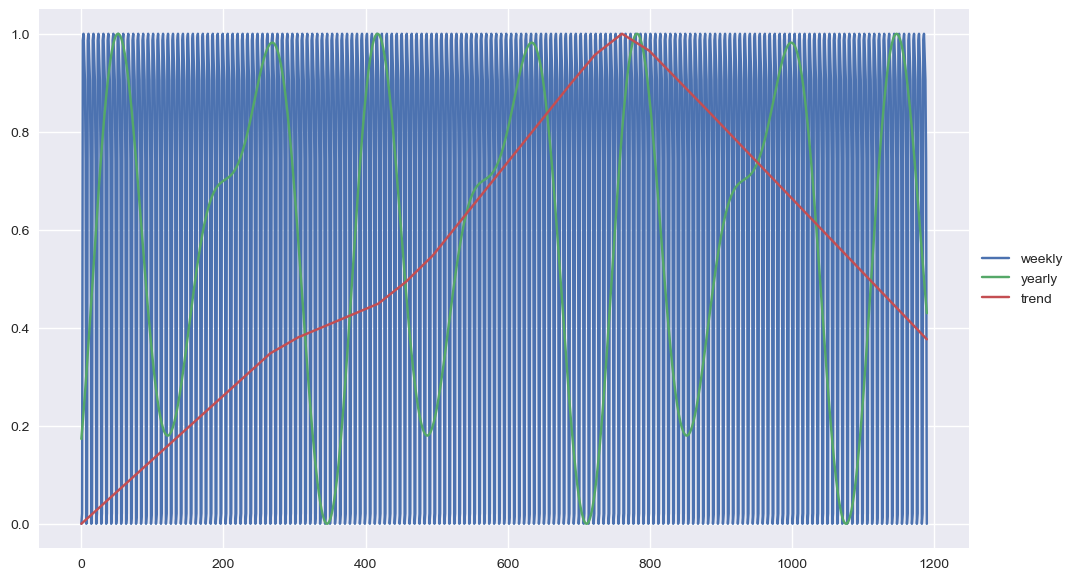

In [14]:
season_extracted_df.weekly.plot()
season_extracted_df.yearly.plot()
season_extracted_df.trend.plot()
plt.legend(loc="center left", bbox_to_anchor=[1,0,.5,1])

In [15]:
test_data_pivot_scaled = data_country_subset.copy()
# scale the data each column by its abs max except date, and save each scale in a dict
scale_dict = {}
for col in data_country_subset.drop(columns=["date", "market"]).columns:
    scale_dict[col] = data_country_subset[col].abs().max()
    test_data_pivot_scaled[col] = data_country_subset[col] / data_country_subset[col].abs().max()
test_data_pivot_scaled.head()

,date,market,kpi_registrations,paidm_soc_fb_excl_cbpr2_imp,paidm_dsp_google_imp,paidm_search_generic_google_imp,paidm_search_brand_google_imp,paidm_dsp_ttd_imp,paidm_search_generic_apple_imp,paidm_search_brand_apple_imp,...,paidm_soc_tw_imp,paidm_soc_tiktok_imp,paidm_soc_twitter_tiktok_imp,paidm_soc_reddit_imp,paidm_audio_weighted_imp,paidm_audio_podscribe_imp,paidm_tv_imp,weekly,yearly,trend
0,2022-01-01,GBR,0.342554,0.116797,0.189836,0.125270,0.0,0.0,NaN,NaN,...,0.290116,0.748735,0.819443,0.0,0.003071,0.0,0.0,2.040257e-12,0.173115,0.000000
1,2022-01-02,GBR,0.455491,0.108294,0.170470,0.178334,0.0,0.0,NaN,NaN,...,0.228132,0.808361,0.834679,0.0,0.002566,0.0,0.0,2.117716e-02,0.190261,0.001308
2,2022-01-03,GBR,0.468386,0.114876,0.261147,0.243576,0.0,0.0,NaN,NaN,...,0.189156,0.775224,0.783047,0.0,0.001987,0.0,0.0,9.867558e-01,0.208025,0.002616
3,2022-01-04,GBR,0.505824,0.101663,0.234506,0.269965,0.0,0.0,NaN,NaN,...,0.163942,0.694584,0.698338,0.0,0.001879,0.0,0.0,1.000000e+00,0.226371,0.003924
4,2022-01-05,GBR,0.551581,0.092481,0.269020,0.250458,0.0,0.0,NaN,NaN,...,0.211444,0.743935,0.769033,0.0,0.001906,0.0,0.0,9.545953e-01,0.245264,0.005232


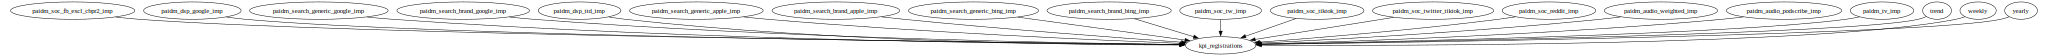

In [16]:
# Create base dag. All impression columns are independent of each other, and have direct effects on the target variable.
# Create a directed graph using graphviz
dot = graphviz.Digraph(comment='Causal Discovery Graph')

# Add nodes for impression columns
for col in impression_columns:
    dot.node(col.lower())

# Add node for KPI registrations
dot.node("kpi_registrations")

# Add edges from KPI registrations to impression columns
for col in impression_columns:
    dot.edge(col.lower(), "kpi_registrations")

# Add edges for seasonality and trend components
dot.node("trend")
dot.node("weekly")
dot.node("yearly")

dot.edge("trend", "kpi_registrations")
dot.edge("weekly", "kpi_registrations")
dot.edge("yearly", "kpi_registrations")

# Display the graph
dot

# Check independence from seasonal effects

In [17]:
facebook_dummy_idata1, facebook_dummy_model1 = build_and_sample_model(
    test_data_pivot_scaled[["date", "kpi_registrations", "paidm_soc_fb_excl_cbpr2_imp"]].fillna(0), 
    "kpi_registrations ~ paidm_soc_fb_excl_cbpr2_imp"
)
facebook_dummy_idata2, facebook_dummy_model2 = build_and_sample_model(
    test_data_pivot_scaled[["date", "kpi_registrations", "paidm_soc_fb_excl_cbpr2_imp", "trend"]].fillna(0), 
    "kpi_registrations ~ paidm_soc_fb_excl_cbpr2_imp + trend"
)
facebook_dummy_idata3, facebook_dummy_model3 = build_and_sample_model(
    test_data_pivot_scaled[["date", "kpi_registrations", "paidm_soc_fb_excl_cbpr2_imp", "trend", "weekly"]].fillna(0),
    "kpi_registrations ~ paidm_soc_fb_excl_cbpr2_imp + trend + weekly"
)
facebook_dummy_idata4, facebook_dummy_model4 = build_and_sample_model(
    test_data_pivot_scaled[["date", "kpi_registrations", "paidm_soc_fb_excl_cbpr2_imp", "trend", "yearly"]].fillna(0),
    "kpi_registrations ~ paidm_soc_fb_excl_cbpr2_imp + trend + yearly"
)

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

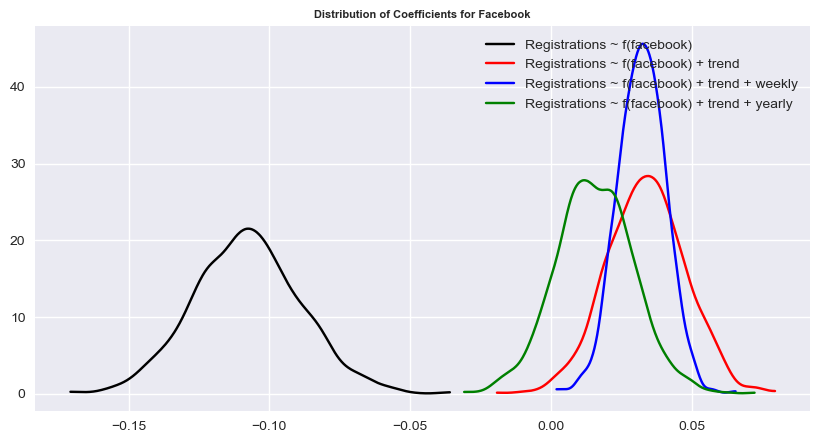

In [18]:
# Create a plot of the distributions comparing the coeff for facebook
channel_name = "paidm_soc_fb_excl_cbpr2_imp"

fig, ax = plt.subplots(figsize=(10, 5))
az.plot_dist(facebook_dummy_idata1.posterior["gamma"].sel(channel=f"{channel_name}"), ax=ax, label='Registrations ~ f(facebook)', color="black")
az.plot_dist(facebook_dummy_idata2.posterior["gamma"].sel(channel=f"{channel_name}"), ax=ax, label='Registrations ~ f(facebook) + trend', color="red")
az.plot_dist(facebook_dummy_idata3.posterior["gamma"].sel(channel=f"{channel_name}"), ax=ax, label='Registrations ~ f(facebook) + trend + weekly', color="blue")
az.plot_dist(facebook_dummy_idata4.posterior["gamma"].sel(channel=f"{channel_name}"), ax=ax, label='Registrations ~ f(facebook) + trend + yearly', color="green")

ax.set_title("Distribution of Coefficients for Facebook")
ax.legend(loc="upper right")

plt.show()

In [19]:
analysis1 = MediationAnalysis(data=test_data_pivot_scaled, x="trend", m="paidm_soc_fb_excl_cbpr2_imp", y="kpi_registrations")
analysis1.build_model()
analysis1.fit()
print(analysis1.get_report_individual("paidm_soc_fb_excl_cbpr2_imp"))

**Bayesian Mediation Analysis for mediator 'paidm_soc_fb_excl_cbpr2_imp'** (95% HDI)
Variables: trend (predictor), paidm_soc_fb_excl_cbpr2_imp (mediator), kpi_registrations (outcome).
- Path a (trend → paidm_soc_fb_excl_cbpr2_imp) is credibly negative (mean = -0.186).
- Path b (paidm_soc_fb_excl_cbpr2_imp → kpi_registrations, controlling for trend) is credibly positive (mean = 0.034).
- Indirect effect (a×b) is credibly negative (mean = -0.006).
- Direct effect (c') is credibly positive (mean = 0.325).
- Total effect (c) is credibly positive (mean = 0.318).

It appears that paidm_soc_fb_excl_cbpr2_imp partially mediates the effect of trend on kpi_registrations.


## Check all channels from seasons

In [20]:
for channel_name in impression_columns:
    print("--------------------------------")
    analysis = MediationAnalysis(data=test_data_pivot_scaled.fillna(0), x="trend", m=channel_name.lower(), y="kpi_registrations")
    analysis.build_model()
    analysis.fit()
    mediation_type = analysis.get_mediation_type()
    print(f"Mediation type for {channel_name}: {mediation_type}")
    if mediation_type == "full" or mediation_type == "partial":
        print(analysis.get_report_individual(channel_name.lower()))
    print("--------------------------------")

--------------------------------
Mediation type for PAIDM_SOC_FB_EXCL_CBPR2_IMP: partial
**Bayesian Mediation Analysis for mediator 'paidm_soc_fb_excl_cbpr2_imp'** (95% HDI)
Variables: trend (predictor), paidm_soc_fb_excl_cbpr2_imp (mediator), kpi_registrations (outcome).
- Path a (trend → paidm_soc_fb_excl_cbpr2_imp) is credibly negative (mean = -0.186).
- Path b (paidm_soc_fb_excl_cbpr2_imp → kpi_registrations, controlling for trend) is credibly positive (mean = 0.034).
- Indirect effect (a×b) is credibly negative (mean = -0.006).
- Direct effect (c') is credibly positive (mean = 0.325).
- Total effect (c) is credibly positive (mean = 0.318).

It appears that paidm_soc_fb_excl_cbpr2_imp partially mediates the effect of trend on kpi_registrations.
--------------------------------
--------------------------------
Mediation type for PAIDM_DSP_GOOGLE_IMP: partial
**Bayesian Mediation Analysis for mediator 'paidm_dsp_google_imp'** (95% HDI)
Variables: trend (predictor), paidm_dsp_google_i

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Mediation type for PAIDM_SEARCH_GENERIC_APPLE_IMP: absent
--------------------------------
--------------------------------


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Mediation type for PAIDM_SEARCH_BRAND_APPLE_IMP: absent
--------------------------------
--------------------------------
Mediation type for PAIDM_SEARCH_GENERIC_BING_IMP: partial
**Bayesian Mediation Analysis for mediator 'paidm_search_generic_bing_imp'** (95% HDI)
Variables: trend (predictor), paidm_search_generic_bing_imp (mediator), kpi_registrations (outcome).
- Path a (trend → paidm_search_generic_bing_imp) is credibly positive (mean = 0.040).
- Path b (paidm_search_generic_bing_imp → kpi_registrations, controlling for trend) is credibly positive (mean = 0.194).
- Indirect effect (a×b) is credibly positive (mean = 0.008).
- Direct effect (c') is credibly positive (mean = 0.311).
- Total effect (c) is credibly positive (mean = 0.318).

It appears that paidm_search_generic_bing_imp partially mediates the effect of trend on kpi_registrations.
--------------------------------
--------------------------------
Mediation type for PAIDM_SEARCH_BRAND_BING_IMP: absent
---------------------

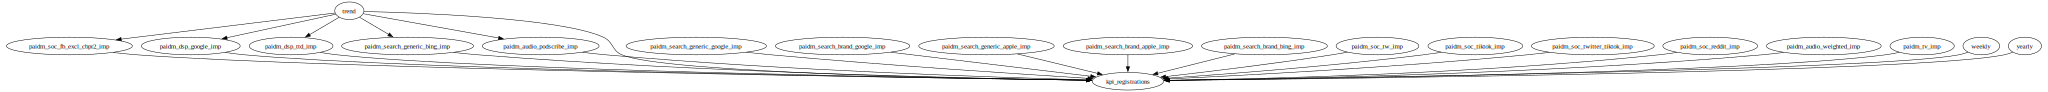

In [21]:
# Add nodes in the graphviz graph from trend to paidm_soc_fb_excl_cbpr2_imp, paidm_dsp_google_imp, paidm_dsp_ttd_imp, paidm_search_generic_bing_imp, paidm_audio_podscribe_imp
dot.edge("trend", "paidm_soc_fb_excl_cbpr2_imp")
dot.edge("trend", "paidm_dsp_google_imp")
dot.edge("trend", "paidm_dsp_ttd_imp")
dot.edge("trend", "paidm_search_generic_bing_imp")
dot.edge("trend", "paidm_audio_podscribe_imp")
dot

In [22]:
for channel_name in impression_columns:
    print("--------------------------------")
    analysis = MediationAnalysis(data=test_data_pivot_scaled.fillna(0), x="weekly", m=channel_name.lower(), y="kpi_registrations")
    analysis.build_model()
    analysis.fit()
    mediation_type = analysis.get_mediation_type()
    print(f"Mediation type for {channel_name}: {mediation_type}")
    if mediation_type == "full" or mediation_type == "partial":
        print(analysis.get_report_individual(channel_name.lower()))
    print("--------------------------------")

--------------------------------
Mediation type for PAIDM_SOC_FB_EXCL_CBPR2_IMP: absent
--------------------------------
--------------------------------
Mediation type for PAIDM_DSP_GOOGLE_IMP: absent
--------------------------------
--------------------------------
Mediation type for PAIDM_SEARCH_GENERIC_GOOGLE_IMP: partial
**Bayesian Mediation Analysis for mediator 'paidm_search_generic_google_imp'** (95% HDI)
Variables: weekly (predictor), paidm_search_generic_google_imp (mediator), kpi_registrations (outcome).
- Path a (weekly → paidm_search_generic_google_imp) is credibly positive (mean = 0.070).
- Path b (paidm_search_generic_google_imp → kpi_registrations, controlling for weekly) is credibly positive (mean = 0.061).
- Indirect effect (a×b) is credibly positive (mean = 0.004).
- Direct effect (c') is credibly positive (mean = 0.154).
- Total effect (c) is credibly positive (mean = 0.159).

It appears that paidm_search_generic_google_imp partially mediates the effect of weekly on

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Mediation type for PAIDM_SEARCH_GENERIC_APPLE_IMP: absent
--------------------------------
--------------------------------


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Mediation type for PAIDM_SEARCH_BRAND_APPLE_IMP: absent
--------------------------------
--------------------------------
Mediation type for PAIDM_SEARCH_GENERIC_BING_IMP: partial
**Bayesian Mediation Analysis for mediator 'paidm_search_generic_bing_imp'** (95% HDI)
Variables: weekly (predictor), paidm_search_generic_bing_imp (mediator), kpi_registrations (outcome).
- Path a (weekly → paidm_search_generic_bing_imp) is credibly positive (mean = 0.086).
- Path b (paidm_search_generic_bing_imp → kpi_registrations, controlling for weekly) is credibly positive (mean = 0.115).
- Indirect effect (a×b) is credibly positive (mean = 0.010).
- Direct effect (c') is credibly positive (mean = 0.149).
- Total effect (c) is credibly positive (mean = 0.159).

It appears that paidm_search_generic_bing_imp partially mediates the effect of weekly on kpi_registrations.
--------------------------------
--------------------------------
Mediation type for PAIDM_SEARCH_BRAND_BING_IMP: absent
-----------------

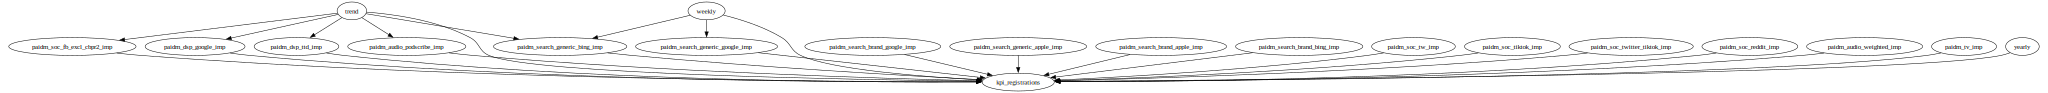

In [23]:
# Add nodes in the graphviz graph from weekly to paidm_search_generic_bing_imp, paidm_search_generic_google_imp, 
dot.edge("weekly", "paidm_search_generic_bing_imp")
dot.edge("weekly", "paidm_search_generic_google_imp")

dot

In [24]:
for channel_name in impression_columns:
    print("--------------------------------")
    analysis = MediationAnalysis(data=test_data_pivot_scaled.fillna(0), x="yearly", m=channel_name.lower(), y="kpi_registrations")
    analysis.build_model()
    analysis.fit()
    mediation_type = analysis.get_mediation_type()
    print(f"Mediation type for {channel_name}: {mediation_type}")
    if mediation_type == "full" or mediation_type == "partial":
        print(analysis.get_report_individual(channel_name.lower()))
    print("--------------------------------")

--------------------------------
Mediation type for PAIDM_SOC_FB_EXCL_CBPR2_IMP: partial
**Bayesian Mediation Analysis for mediator 'paidm_soc_fb_excl_cbpr2_imp'** (95% HDI)
Variables: yearly (predictor), paidm_soc_fb_excl_cbpr2_imp (mediator), kpi_registrations (outcome).
- Path a (yearly → paidm_soc_fb_excl_cbpr2_imp) is credibly positive (mean = 0.087).
- Path b (paidm_soc_fb_excl_cbpr2_imp → kpi_registrations, controlling for yearly) is credibly negative (mean = -0.126).
- Indirect effect (a×b) is credibly negative (mean = -0.011).
- Direct effect (c') is credibly positive (mean = 0.077).
- Total effect (c) is credibly positive (mean = 0.066).

It appears that paidm_soc_fb_excl_cbpr2_imp partially mediates the effect of yearly on kpi_registrations.
--------------------------------
--------------------------------
Mediation type for PAIDM_DSP_GOOGLE_IMP: partial
**Bayesian Mediation Analysis for mediator 'paidm_dsp_google_imp'** (95% HDI)
Variables: yearly (predictor), paidm_dsp_goo

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Mediation type for PAIDM_SEARCH_GENERIC_APPLE_IMP: absent
--------------------------------
--------------------------------


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Mediation type for PAIDM_SEARCH_BRAND_APPLE_IMP: absent
--------------------------------
--------------------------------
Mediation type for PAIDM_SEARCH_GENERIC_BING_IMP: absent
--------------------------------
--------------------------------
Mediation type for PAIDM_SEARCH_BRAND_BING_IMP: partial
**Bayesian Mediation Analysis for mediator 'paidm_search_brand_bing_imp'** (95% HDI)
Variables: yearly (predictor), paidm_search_brand_bing_imp (mediator), kpi_registrations (outcome).
- Path a (yearly → paidm_search_brand_bing_imp) is credibly positive (mean = 0.173).
- Path b (paidm_search_brand_bing_imp → kpi_registrations, controlling for yearly) is credibly positive (mean = 0.049).
- Indirect effect (a×b) is credibly positive (mean = 0.009).
- Direct effect (c') is credibly positive (mean = 0.057).
- Total effect (c) is credibly positive (mean = 0.065).

It appears that paidm_search_brand_bing_imp partially mediates the effect of yearly on kpi_registrations.
---------------------------

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Mediation type for PAIDM_TV_IMP: absent
--------------------------------


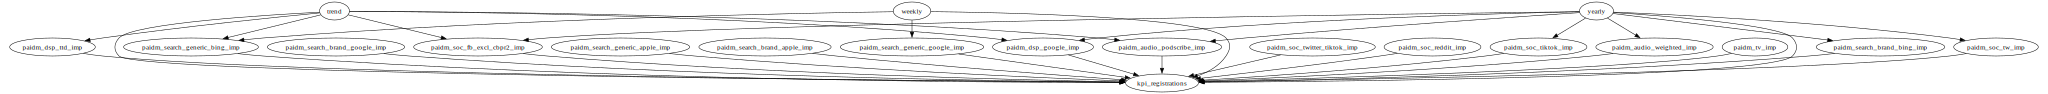

In [25]:
# Add nodes in the graphviz graph from yearly to paidm_soc_fb_excl_cbpr2_imp, paidm_dsp_google_imp, paidm_search_brand_bing_imp, paidm_soc_tw_imp, paidm_soc_tiktok_imp, paidm_audio_weighted_imp, paidm_audio_podscribe_imp
dot.edge("yearly", "paidm_soc_fb_excl_cbpr2_imp")
dot.edge("yearly", "paidm_dsp_google_imp")
dot.edge("yearly", "paidm_search_brand_bing_imp")
dot.edge("yearly", "paidm_soc_tw_imp")
dot.edge("yearly", "paidm_soc_tiktok_imp")
dot.edge("yearly", "paidm_audio_weighted_imp")
dot.edge("yearly", "paidm_audio_podscribe_imp")

dot

# Channel relationships

Sampling: [intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

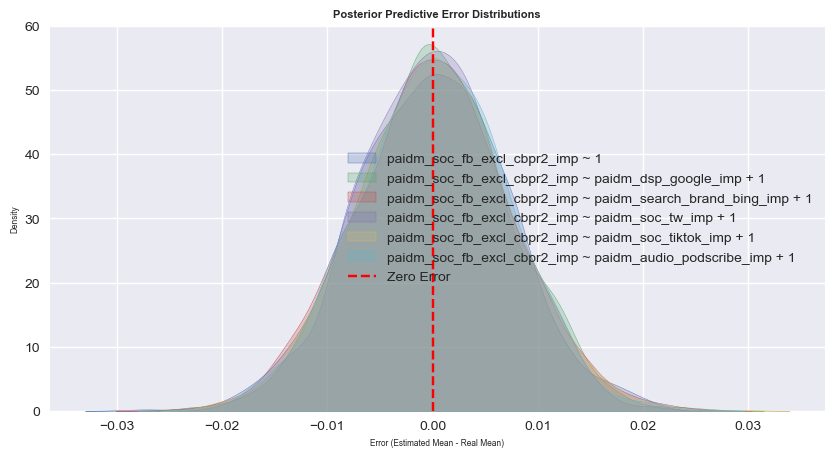

In [26]:
identifier_facebook = ParentCandidateIdentifier(
    data=test_data_pivot_scaled.fillna(0), 
    node="paidm_soc_fb_excl_cbpr2_imp", 
    possible_parents=["paidm_dsp_google_imp", "paidm_search_brand_bing_imp", "paidm_soc_tw_imp", "paidm_soc_tiktok_imp", "paidm_audio_podscribe_imp"], 
    epsilon=0.005
)
decision_info = identifier_facebook.identify_candidate_parents()
identifier_facebook.plot_distributions()

In [27]:
decision_info["candidate_parents"]

['paidm_dsp_google_imp']

In [28]:
impression_columns

['PAIDM_SOC_FB_EXCL_CBPR2_IMP',
 'PAIDM_DSP_GOOGLE_IMP',
 'PAIDM_SEARCH_GENERIC_GOOGLE_IMP',
 'PAIDM_SEARCH_BRAND_GOOGLE_IMP',
 'PAIDM_DSP_TTD_IMP',
 'PAIDM_SEARCH_GENERIC_APPLE_IMP',
 'PAIDM_SEARCH_BRAND_APPLE_IMP',
 'PAIDM_SEARCH_GENERIC_BING_IMP',
 'PAIDM_SEARCH_BRAND_BING_IMP',
 'PAIDM_SOC_TW_IMP',
 'PAIDM_SOC_TIKTOK_IMP',
 'PAIDM_SOC_TWITTER_TIKTOK_IMP',
 'PAIDM_SOC_REDDIT_IMP',
 'PAIDM_AUDIO_WEIGHTED_IMP',
 'PAIDM_AUDIO_PODSCRIBE_IMP',
 'PAIDM_TV_IMP']

Sampling: [intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

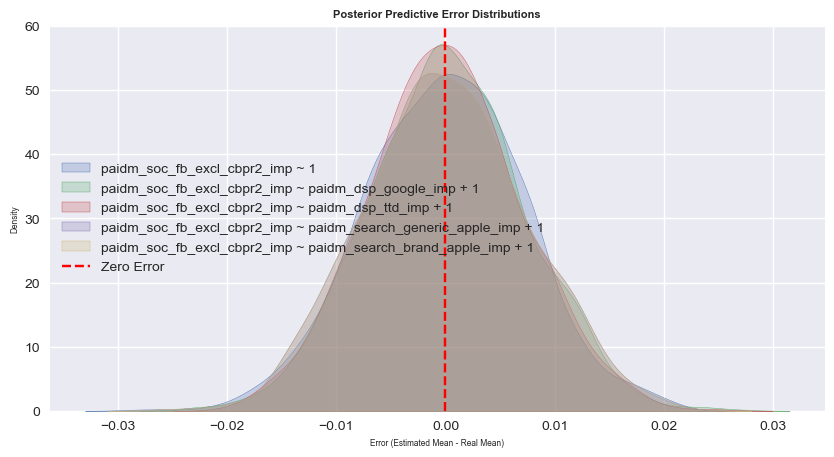

In [29]:
# Second lot
identifier_facebook = ParentCandidateIdentifier(
    data=test_data_pivot_scaled.fillna(0), 
    node="paidm_soc_fb_excl_cbpr2_imp", 
    possible_parents=["paidm_dsp_google_imp", "paidm_dsp_ttd_imp", "paidm_search_generic_apple_imp", "paidm_search_brand_apple_imp"], 
    epsilon=0.005
)
decision_info = identifier_facebook.identify_candidate_parents()
identifier_facebook.plot_distributions()

In [30]:
decision_info["candidate_parents"]

['paidm_dsp_ttd_imp']

Sampling: [intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

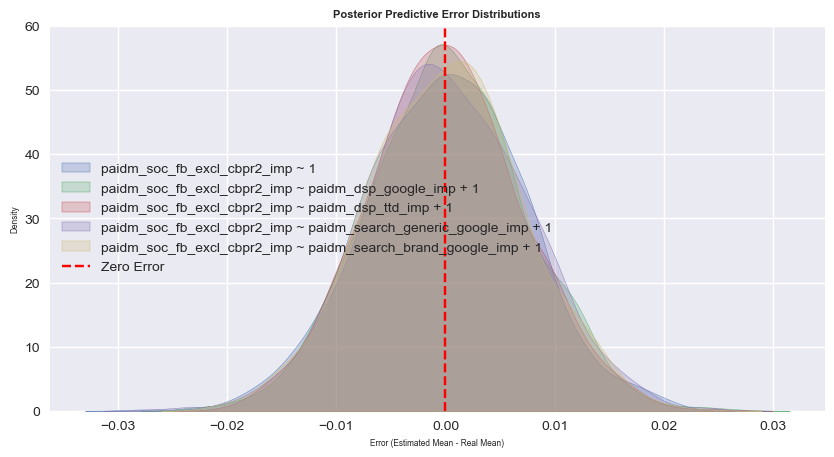

In [31]:
# Third lot
identifier_facebook = ParentCandidateIdentifier(
    data=test_data_pivot_scaled.fillna(0), 
    node="paidm_soc_fb_excl_cbpr2_imp", 
    possible_parents=["paidm_dsp_google_imp", "paidm_dsp_ttd_imp", "paidm_search_generic_google_imp", "paidm_search_brand_google_imp"], 
    epsilon=0.005
)
decision_info = identifier_facebook.identify_candidate_parents()
identifier_facebook.plot_distributions()

Sampling: [intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

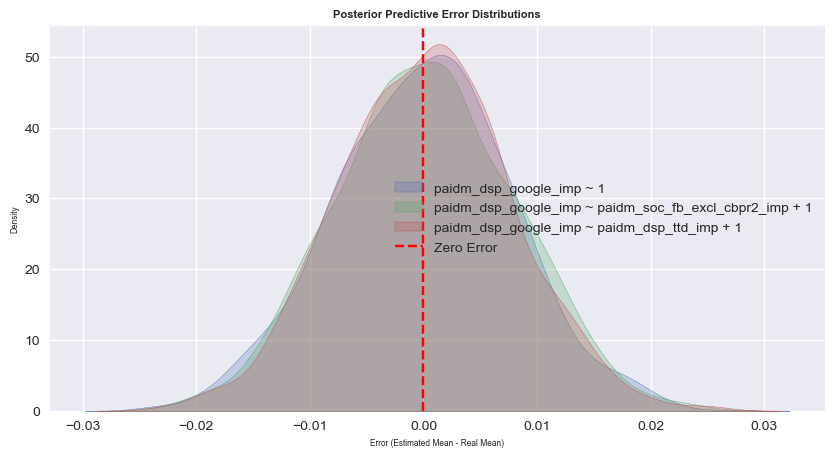

In [32]:
# reverse
identifier_facebook_reverse1 = ParentCandidateIdentifier(
    data=test_data_pivot_scaled.fillna(0), 
    node="paidm_dsp_google_imp", 
    possible_parents=["paidm_soc_fb_excl_cbpr2_imp", "paidm_dsp_ttd_imp"], 
    epsilon=0.005
)
decision_info = identifier_facebook_reverse1.identify_candidate_parents()
identifier_facebook_reverse1.plot_distributions()

Sampling: [intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

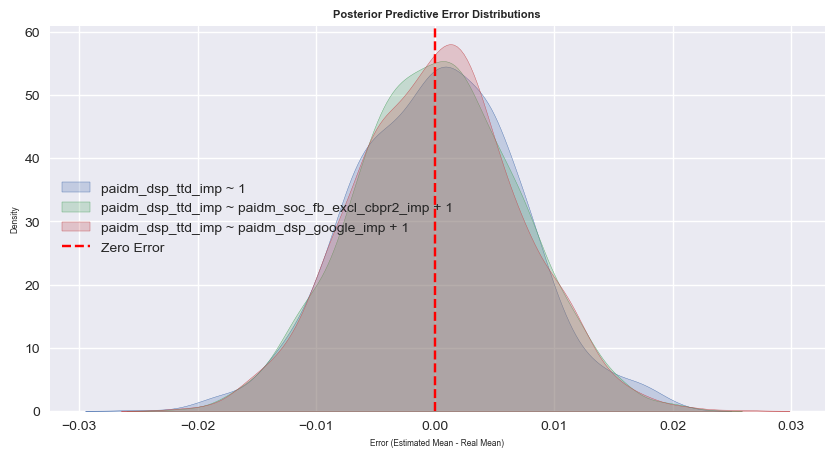

In [33]:
# reverse
identifier_facebook_reverse2 = ParentCandidateIdentifier(
    data=test_data_pivot_scaled.fillna(0),
    node="paidm_dsp_ttd_imp", 
    possible_parents=["paidm_soc_fb_excl_cbpr2_imp", "paidm_dsp_google_imp"], 
    epsilon=0.005
)
decision_info = identifier_facebook_reverse2.identify_candidate_parents()
identifier_facebook_reverse2.plot_distributions()

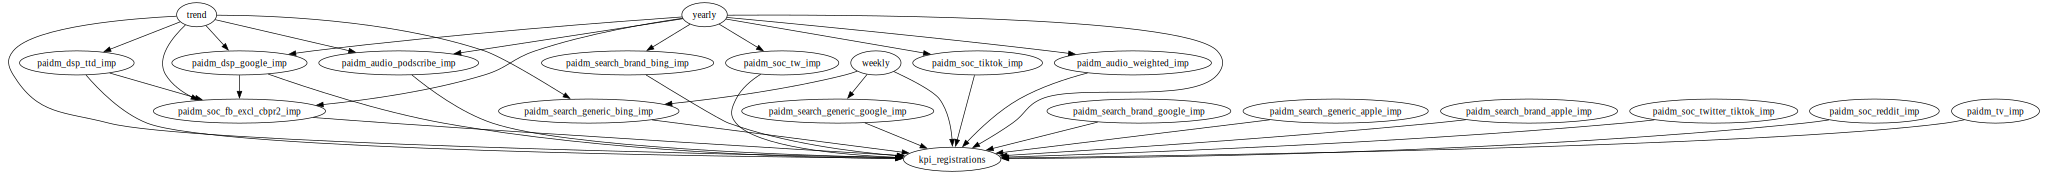

In [34]:
# Add edges to the graph from google and ttd display to facebook
dot.edge("paidm_dsp_google_imp", "paidm_soc_fb_excl_cbpr2_imp")
dot.edge("paidm_dsp_ttd_imp", "paidm_soc_fb_excl_cbpr2_imp")
dot

Sampling: [intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

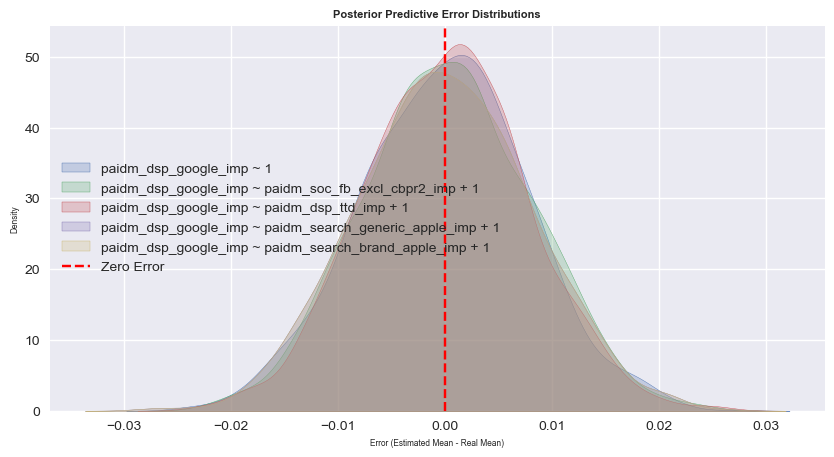

In [35]:
# Second lot
identifier_google = ParentCandidateIdentifier(
    data=test_data_pivot_scaled.fillna(0), 
    node="paidm_dsp_google_imp", 
    possible_parents=["paidm_soc_fb_excl_cbpr2_imp", "paidm_dsp_ttd_imp", "paidm_search_generic_apple_imp", "paidm_search_brand_apple_imp"], 
    epsilon=0.005
)
decision_info = identifier_google.identify_candidate_parents()
identifier_google.plot_distributions()

In [36]:
decision_info["candidate_parents"]
# Second lot

['paidm_dsp_ttd_imp']

Sampling: [intercept, likelihood, sigma]
There were 1453 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
There were 275 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
There were 547 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
There were 123 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
There were 1946 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
There were 747 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
There were 762 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
There were 449 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
There were 456 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
There were 470 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
There were 295 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

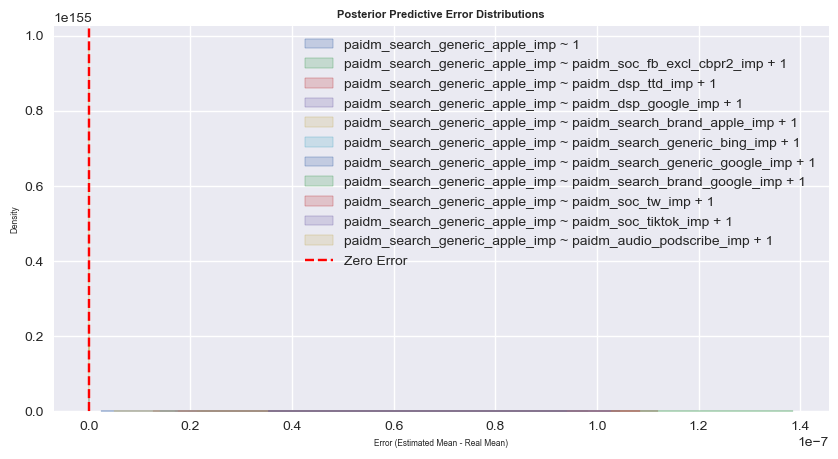

In [37]:
# Second lot
identifier_apple = ParentCandidateIdentifier(
    data=test_data_pivot_scaled.fillna(0), 
    node="paidm_search_generic_apple_imp", 
    possible_parents=[
        "paidm_soc_fb_excl_cbpr2_imp", "paidm_dsp_ttd_imp", "paidm_dsp_google_imp", 
        "paidm_search_brand_apple_imp", "paidm_search_generic_bing_imp", "paidm_search_generic_google_imp", 
        "paidm_search_brand_google_imp", "paidm_soc_tw_imp", "paidm_soc_tiktok_imp", "paidm_audio_podscribe_imp"
    ], 
    epsilon=0.005
)
decision_info = identifier_apple.identify_candidate_parents()
identifier_apple.plot_distributions()

Sampling: [intercept, likelihood, sigma]
There were 1453 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
There were 275 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
There were 547 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
There were 123 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
There were 1946 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
There were 747 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
There were 762 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
There were 449 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
There were 456 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
There were 470 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
There were 295 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

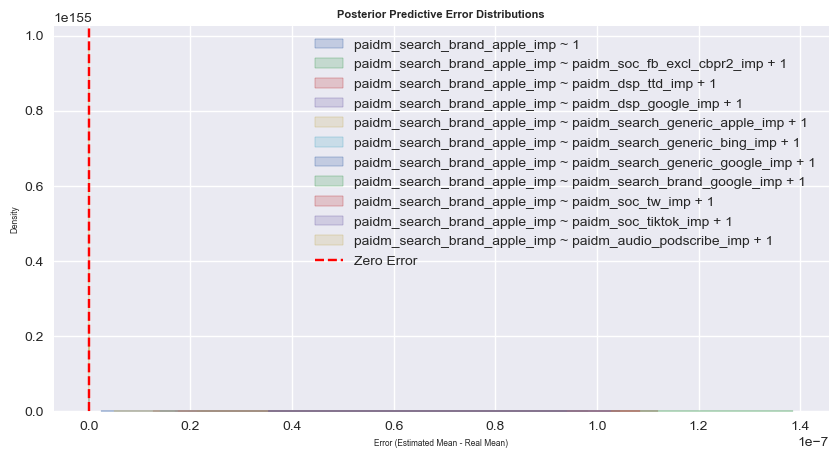

In [38]:
# Second lot
identifier_apple_brand = ParentCandidateIdentifier(
    data=test_data_pivot_scaled.fillna(0), 
    node="paidm_search_brand_apple_imp", 
    possible_parents=[
        "paidm_soc_fb_excl_cbpr2_imp", "paidm_dsp_ttd_imp", "paidm_dsp_google_imp", 
        "paidm_search_generic_apple_imp", "paidm_search_generic_bing_imp", "paidm_search_generic_google_imp", 
        "paidm_search_brand_google_imp", "paidm_soc_tw_imp", "paidm_soc_tiktok_imp", "paidm_audio_podscribe_imp"
    ], 
    epsilon=0.005
)
decision_info = identifier_apple_brand.identify_candidate_parents()
identifier_apple_brand.plot_distributions()

Sampling: [intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

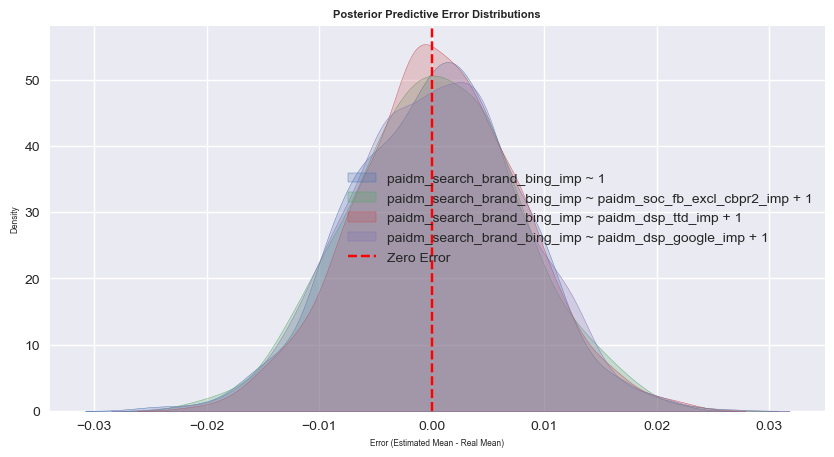

In [39]:
# Second lot
identifier_bing_brand = ParentCandidateIdentifier(
    data=test_data_pivot_scaled.fillna(0), 
    node="paidm_search_brand_bing_imp", 
    possible_parents=[
        "paidm_soc_fb_excl_cbpr2_imp", "paidm_dsp_ttd_imp", "paidm_dsp_google_imp", 
        # "paidm_search_generic_apple_imp", "paidm_search_brand_apple_imp", "paidm_search_generic_google_imp", 
        # "paidm_search_brand_google_imp", "paidm_soc_tw_imp", "paidm_soc_tiktok_imp", "paidm_audio_podscribe_imp"
    ], 
    epsilon=0.005
)
decision_info = identifier_bing_brand.identify_candidate_parents()
identifier_bing_brand.plot_distributions()

Sampling: [intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

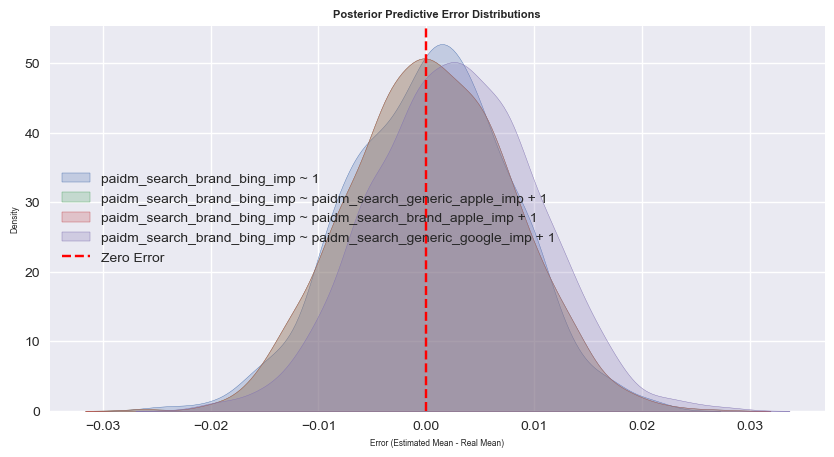

In [40]:
# Second lot
identifier_bing_brand = ParentCandidateIdentifier(
    data=test_data_pivot_scaled.fillna(0), 
    node="paidm_search_brand_bing_imp", 
    possible_parents=[
        # "paidm_soc_fb_excl_cbpr2_imp", "paidm_dsp_ttd_imp", "paidm_dsp_google_imp", 
        "paidm_search_generic_apple_imp", "paidm_search_brand_apple_imp", "paidm_search_generic_google_imp", 
        # "paidm_search_brand_google_imp", "paidm_soc_tw_imp", "paidm_soc_tiktok_imp", "paidm_audio_podscribe_imp"
    ], 
    epsilon=0.005
)
decision_info = identifier_bing_brand.identify_candidate_parents()
identifier_bing_brand.plot_distributions()

Sampling: [intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

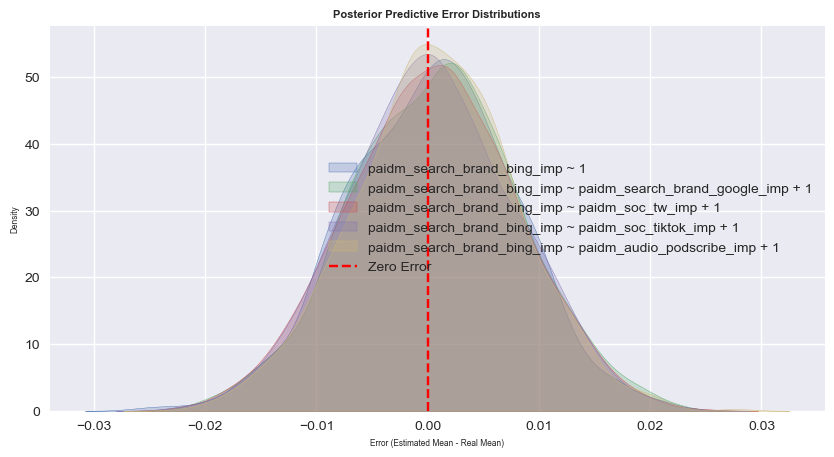

In [41]:
# Second lot
identifier_bing_brand = ParentCandidateIdentifier(
    data=test_data_pivot_scaled.fillna(0), 
    node="paidm_search_brand_bing_imp", 
    possible_parents=[
        # "paidm_soc_fb_excl_cbpr2_imp", "paidm_dsp_ttd_imp", "paidm_dsp_google_imp", 
        # "paidm_search_generic_apple_imp", "paidm_search_brand_apple_imp", "paidm_search_generic_google_imp", 
        "paidm_search_brand_google_imp", "paidm_soc_tw_imp", "paidm_soc_tiktok_imp", "paidm_audio_podscribe_imp"
    ], 
    epsilon=0.005
)
decision_info = identifier_bing_brand.identify_candidate_parents()
identifier_bing_brand.plot_distributions()

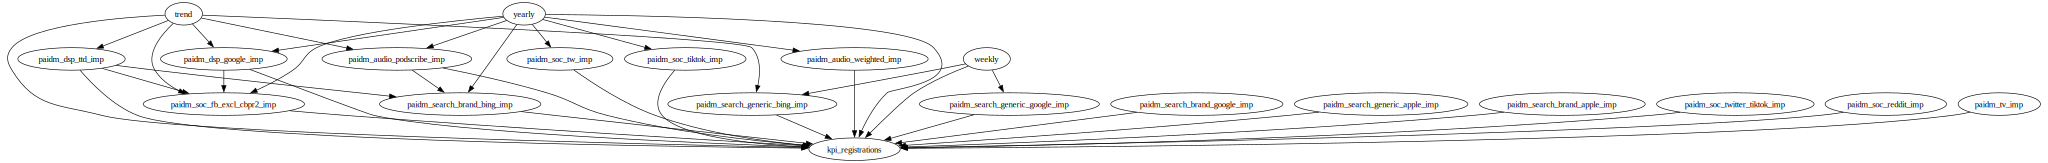

In [42]:
# Add edges to the graph from google and ttd display to facebook
dot.edge("paidm_audio_podscribe_imp", "paidm_search_brand_bing_imp")
dot.edge("paidm_dsp_ttd_imp", "paidm_search_brand_bing_imp")
dot

Sampling: [intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

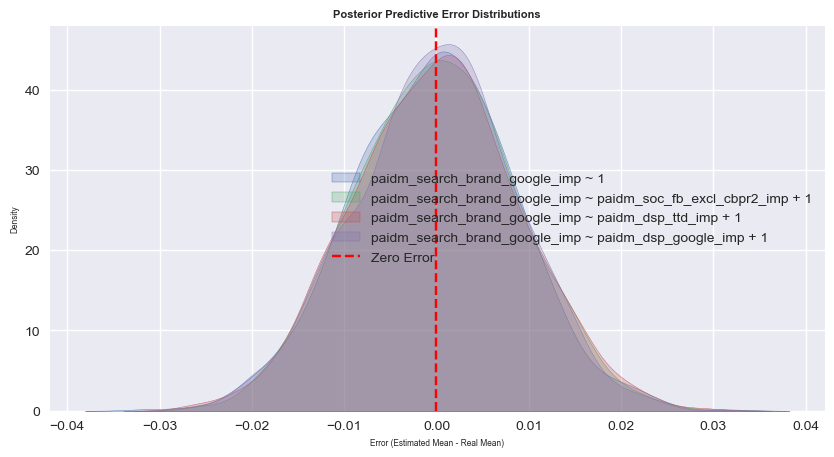

In [43]:
# Second lot
identifier_google_brand = ParentCandidateIdentifier(
    data=test_data_pivot_scaled.fillna(0), 
    node="paidm_search_brand_google_imp", 
    possible_parents=[
        "paidm_soc_fb_excl_cbpr2_imp", "paidm_dsp_ttd_imp", "paidm_dsp_google_imp", 
        # "paidm_search_generic_apple_imp", "paidm_search_brand_apple_imp", "paidm_search_generic_google_imp", 
        # "paidm_search_brand_google_imp", "paidm_soc_tw_imp", "paidm_soc_tiktok_imp", "paidm_audio_podscribe_imp"
    ], 
    epsilon=0.005
)
decision_info = identifier_google_brand.identify_candidate_parents()
identifier_google_brand.plot_distributions()

Sampling: [intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

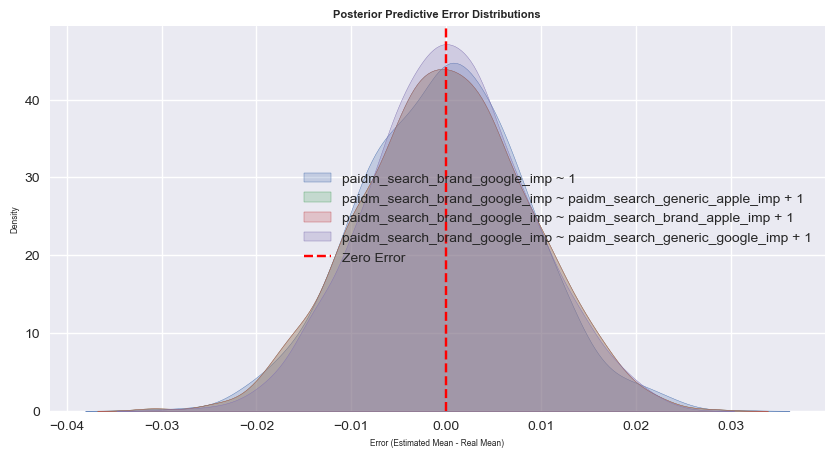

In [44]:
# Second lot
identifier_google_brand = ParentCandidateIdentifier(
    data=test_data_pivot_scaled.fillna(0), 
    node="paidm_search_brand_google_imp", 
    possible_parents=[
        # "paidm_soc_fb_excl_cbpr2_imp", "paidm_dsp_ttd_imp", "paidm_dsp_google_imp", 
        "paidm_search_generic_apple_imp", "paidm_search_brand_apple_imp", "paidm_search_generic_google_imp", 
        # "paidm_search_brand_google_imp", "paidm_soc_tw_imp", "paidm_soc_tiktok_imp", "paidm_audio_podscribe_imp"
    ], 
    epsilon=0.005
)
decision_info = identifier_google_brand.identify_candidate_parents()
identifier_google_brand.plot_distributions()

Sampling: [intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

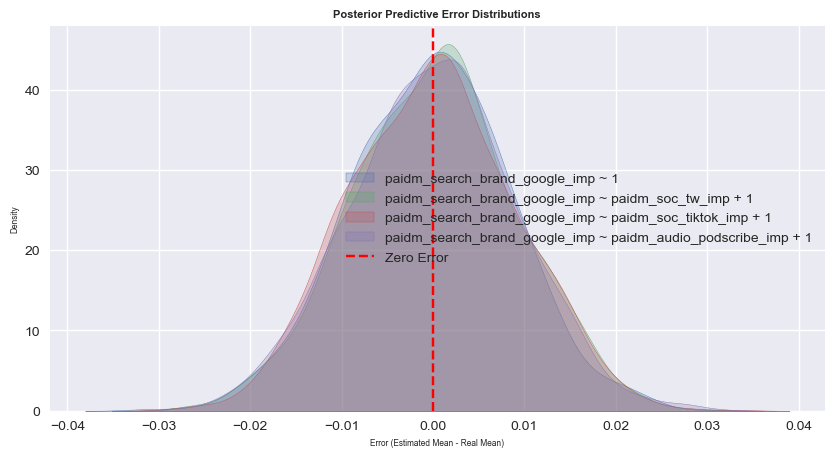

In [45]:
# Second lot
identifier_google_brand = ParentCandidateIdentifier(
    data=test_data_pivot_scaled.fillna(0), 
    node="paidm_search_brand_google_imp", 
    possible_parents=[
        # "paidm_soc_fb_excl_cbpr2_imp", "paidm_dsp_ttd_imp", "paidm_dsp_google_imp", 
        # "paidm_search_generic_apple_imp", "paidm_search_brand_apple_imp", "paidm_search_generic_google_imp", 
        "paidm_soc_tw_imp", "paidm_soc_tiktok_imp", "paidm_audio_podscribe_imp"
    ], 
    epsilon=0.005
)
decision_info = identifier_google_brand.identify_candidate_parents()
identifier_google_brand.plot_distributions()

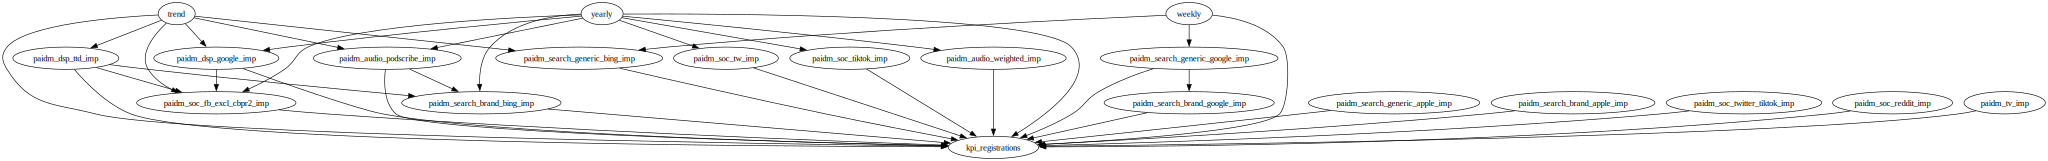

In [46]:
# Add edges to the graph from google and ttd display to facebook
dot.edge("paidm_search_generic_google_imp", "paidm_search_brand_google_imp")
dot

Sampling: [intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

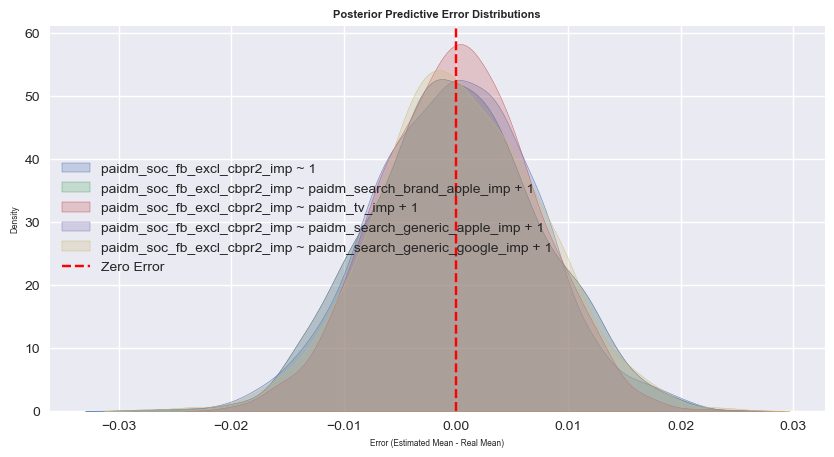

In [47]:
# Second lot
identifier_tv = ParentCandidateIdentifier(
    data=test_data_pivot_scaled.fillna(0), 
    node="paidm_soc_fb_excl_cbpr2_imp", 
    possible_parents=[
        "paidm_search_brand_apple_imp", "paidm_tv_imp", 
        "paidm_search_generic_apple_imp", "paidm_search_brand_apple_imp", "paidm_search_generic_google_imp", 
        # "paidm_soc_tw_imp", "paidm_soc_tiktok_imp", "paidm_audio_podscribe_imp"
    ], 
    epsilon=0.005
)
decision_info = identifier_tv.identify_candidate_parents()
identifier_tv.plot_distributions()

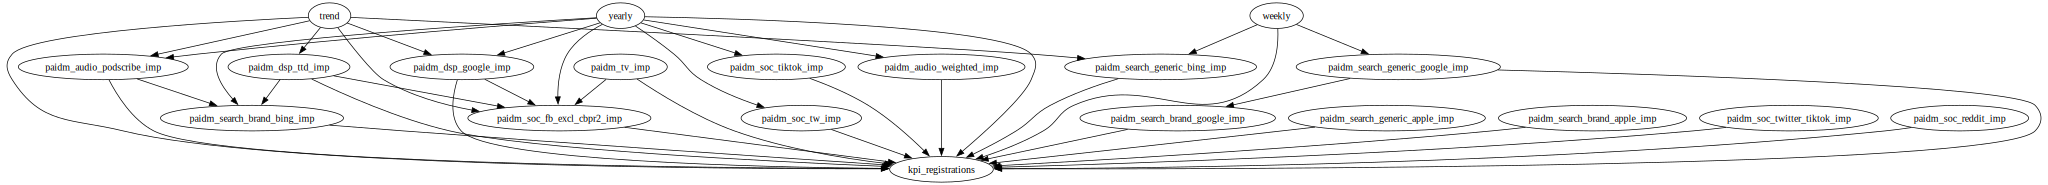

In [48]:
# Add edges to the graph from google and ttd display to facebook
dot.edge("paidm_tv_imp", "paidm_soc_fb_excl_cbpr2_imp")
dot

Sampling: [intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

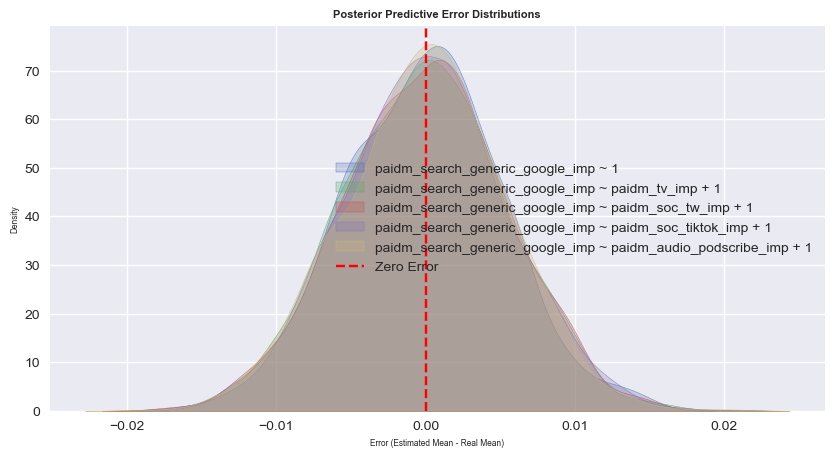

In [49]:
# Second lot
identifier_tv = ParentCandidateIdentifier(
    data=test_data_pivot_scaled.fillna(0), 
    node="paidm_search_generic_google_imp", 
    possible_parents=[
        "paidm_tv_imp", 
        # "paidm_search_generic_apple_imp",
        "paidm_soc_tw_imp", "paidm_soc_tiktok_imp", "paidm_audio_podscribe_imp"
    ], 
    epsilon=0.005
)
decision_info = identifier_tv.identify_candidate_parents()
identifier_tv.plot_distributions()

In [50]:
print(dot.source)

// Causal Discovery Graph
digraph {
	paidm_soc_fb_excl_cbpr2_imp
	paidm_dsp_google_imp
	paidm_search_generic_google_imp
	paidm_search_brand_google_imp
	paidm_dsp_ttd_imp
	paidm_search_generic_apple_imp
	paidm_search_brand_apple_imp
	paidm_search_generic_bing_imp
	paidm_search_brand_bing_imp
	paidm_soc_tw_imp
	paidm_soc_tiktok_imp
	paidm_soc_twitter_tiktok_imp
	paidm_soc_reddit_imp
	paidm_audio_weighted_imp
	paidm_audio_podscribe_imp
	paidm_tv_imp
	kpi_registrations
	paidm_soc_fb_excl_cbpr2_imp -> kpi_registrations
	paidm_dsp_google_imp -> kpi_registrations
	paidm_search_generic_google_imp -> kpi_registrations
	paidm_search_brand_google_imp -> kpi_registrations
	paidm_dsp_ttd_imp -> kpi_registrations
	paidm_search_generic_apple_imp -> kpi_registrations
	paidm_search_brand_apple_imp -> kpi_registrations
	paidm_search_generic_bing_imp -> kpi_registrations
	paidm_search_brand_bing_imp -> kpi_registrations
	paidm_soc_tw_imp -> kpi_registrations
	paidm_soc_tiktok_imp -> kpi_registrations
	pa

In [ ]:
# for channel_name in impression_columns:
print("--------------------------------")
mediator_columns = [col.lower() for col in impression_columns if col.lower() != "paidm_soc_fb_excl_cbpr2_imp"]
for channel_name in mediator_columns:
    analysis = MediationAnalysis(data=test_data_pivot_scaled.fillna(0), x="paidm_soc_fb_excl_cbpr2_imp", m=mediator_columns, y="kpi_registrations")
    analysis.build_model()
    analysis.fit()
    mediation_type = analysis.get_mediation_type()
    print(f"Mediation type for {channel_name}: {mediation_type}")
    if mediation_type == "full" or mediation_type == "partial":
        print(analysis.get_report_individual(channel_name.lower()))
print("--------------------------------")

--------------------------------


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sa

Mediation type for paidm_dsp_google_imp: partial
**Bayesian Mediation Analysis for mediator 'paidm_dsp_google_imp'** (95% HDI)
Variables: paidm_soc_fb_excl_cbpr2_imp (predictor), paidm_dsp_google_imp (mediator), kpi_registrations (outcome).
- Path a (paidm_soc_fb_excl_cbpr2_imp → paidm_dsp_google_imp) is credibly positive (mean = 0.185).
- Path b (paidm_dsp_google_imp → kpi_registrations, controlling for paidm_soc_fb_excl_cbpr2_imp) is credibly negative (mean = -0.174).
- Indirect effect (a×b) is credibly negative (mean = -0.032).
- Direct effect (c') is credibly negative (mean = -0.075).
- Total effect (c) is credibly negative (mean = -0.107).

It appears that paidm_dsp_google_imp partially mediates the effect of paidm_soc_fb_excl_cbpr2_imp on kpi_registrations.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sa

Mediation type for paidm_search_generic_google_imp: partial
**Bayesian Mediation Analysis for mediator 'paidm_search_generic_google_imp'** (95% HDI)
Variables: paidm_soc_fb_excl_cbpr2_imp (predictor), paidm_search_generic_google_imp (mediator), kpi_registrations (outcome).
- Path a (paidm_soc_fb_excl_cbpr2_imp → paidm_search_generic_google_imp) is credibly positive (mean = 0.140).
- Path b (paidm_search_generic_google_imp → kpi_registrations, controlling for paidm_soc_fb_excl_cbpr2_imp) is credibly positive (mean = 0.203).
- Indirect effect (a×b) is credibly positive (mean = 0.029).
- Direct effect (c') is credibly negative (mean = -0.138).
- Total effect (c) is credibly negative (mean = -0.109).

It appears that paidm_search_generic_google_imp partially mediates the effect of paidm_soc_fb_excl_cbpr2_imp on kpi_registrations.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sa

Mediation type for paidm_search_brand_google_imp: partial
**Bayesian Mediation Analysis for mediator 'paidm_search_brand_google_imp'** (95% HDI)
Variables: paidm_soc_fb_excl_cbpr2_imp (predictor), paidm_search_brand_google_imp (mediator), kpi_registrations (outcome).
- Path a (paidm_soc_fb_excl_cbpr2_imp → paidm_search_brand_google_imp) is credibly positive (mean = 0.273).
- Path b (paidm_search_brand_google_imp → kpi_registrations, controlling for paidm_soc_fb_excl_cbpr2_imp) is credibly positive (mean = 0.099).
- Indirect effect (a×b) is credibly positive (mean = 0.027).
- Direct effect (c') is credibly negative (mean = -0.134).
- Total effect (c) is credibly negative (mean = -0.107).

It appears that paidm_search_brand_google_imp partially mediates the effect of paidm_soc_fb_excl_cbpr2_imp on kpi_registrations.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sa

Mediation type for paidm_dsp_ttd_imp: partial
**Bayesian Mediation Analysis for mediator 'paidm_dsp_ttd_imp'** (95% HDI)
Variables: paidm_soc_fb_excl_cbpr2_imp (predictor), paidm_dsp_ttd_imp (mediator), kpi_registrations (outcome).
- Path a (paidm_soc_fb_excl_cbpr2_imp → paidm_dsp_ttd_imp) is credibly negative (mean = -0.326).
- Path b (paidm_dsp_ttd_imp → kpi_registrations, controlling for paidm_soc_fb_excl_cbpr2_imp) is credibly positive (mean = 0.210).
- Indirect effect (a×b) is credibly negative (mean = -0.068).
- Direct effect (c') is credibly negative (mean = -0.039).
- Total effect (c) is credibly negative (mean = -0.107).

It appears that paidm_dsp_ttd_imp partially mediates the effect of paidm_soc_fb_excl_cbpr2_imp on kpi_registrations.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sa

Mediation type for paidm_search_generic_apple_imp: partial
**Bayesian Mediation Analysis for mediator 'paidm_search_generic_apple_imp'** (95% HDI)
Variables: paidm_soc_fb_excl_cbpr2_imp (predictor), paidm_search_generic_apple_imp (mediator), kpi_registrations (outcome).
- Path a (paidm_soc_fb_excl_cbpr2_imp → paidm_search_generic_apple_imp) is weak (HDI includes 0, mean = -0.000).
- Path b (paidm_search_generic_apple_imp → kpi_registrations, controlling for paidm_soc_fb_excl_cbpr2_imp) is credibly negative (mean = -0.630).
- Indirect effect (a×b) is uncertain (HDI includes 0, mean = -0.000).
- Direct effect (c') is credibly negative (mean = -0.137).
- Total effect (c) is credibly negative (mean = -0.137).

Mediation is unclear or absent (the indirect effect includes zero or the total effect is not clearly different from zero).


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sa

Mediation type for paidm_search_brand_apple_imp: partial
**Bayesian Mediation Analysis for mediator 'paidm_search_brand_apple_imp'** (95% HDI)
Variables: paidm_soc_fb_excl_cbpr2_imp (predictor), paidm_search_brand_apple_imp (mediator), kpi_registrations (outcome).
- Path a (paidm_soc_fb_excl_cbpr2_imp → paidm_search_brand_apple_imp) is weak (HDI includes 0, mean = -0.000).
- Path b (paidm_search_brand_apple_imp → kpi_registrations, controlling for paidm_soc_fb_excl_cbpr2_imp) is credibly negative (mean = -0.630).
- Indirect effect (a×b) is uncertain (HDI includes 0, mean = -0.000).
- Direct effect (c') is credibly negative (mean = -0.137).
- Total effect (c) is credibly negative (mean = -0.137).

Mediation is unclear or absent (the indirect effect includes zero or the total effect is not clearly different from zero).


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sa

Mediation type for paidm_search_generic_bing_imp: partial
**Bayesian Mediation Analysis for mediator 'paidm_search_generic_bing_imp'** (95% HDI)
Variables: paidm_soc_fb_excl_cbpr2_imp (predictor), paidm_search_generic_bing_imp (mediator), kpi_registrations (outcome).
- Path a (paidm_soc_fb_excl_cbpr2_imp → paidm_search_generic_bing_imp) is credibly negative (mean = -0.145).
- Path b (paidm_search_generic_bing_imp → kpi_registrations, controlling for paidm_soc_fb_excl_cbpr2_imp) is credibly positive (mean = 0.229).
- Indirect effect (a×b) is credibly negative (mean = -0.033).
- Direct effect (c') is credibly negative (mean = -0.074).
- Total effect (c) is credibly negative (mean = -0.107).

It appears that paidm_search_generic_bing_imp partially mediates the effect of paidm_soc_fb_excl_cbpr2_imp on kpi_registrations.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sa

Mediation type for paidm_search_brand_bing_imp: partial
**Bayesian Mediation Analysis for mediator 'paidm_search_brand_bing_imp'** (95% HDI)
Variables: paidm_soc_fb_excl_cbpr2_imp (predictor), paidm_search_brand_bing_imp (mediator), kpi_registrations (outcome).
- Path a (paidm_soc_fb_excl_cbpr2_imp → paidm_search_brand_bing_imp) is credibly negative (mean = -0.080).
- Path b (paidm_search_brand_bing_imp → kpi_registrations, controlling for paidm_soc_fb_excl_cbpr2_imp) is credibly positive (mean = 0.068).
- Indirect effect (a×b) is credibly negative (mean = -0.005).
- Direct effect (c') is credibly negative (mean = -0.102).
- Total effect (c) is credibly negative (mean = -0.107).

It appears that paidm_search_brand_bing_imp partially mediates the effect of paidm_soc_fb_excl_cbpr2_imp on kpi_registrations.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [55]:
data_country_subset.drop(columns=["date", "market"]).fillna(0)

,kpi_registrations,paidm_soc_fb_excl_cbpr2_imp,paidm_dsp_google_imp,paidm_search_generic_google_imp,paidm_search_brand_google_imp,paidm_dsp_ttd_imp,paidm_search_generic_apple_imp,paidm_search_brand_apple_imp,paidm_search_generic_bing_imp,paidm_search_brand_bing_imp,paidm_soc_tw_imp,paidm_soc_tiktok_imp,paidm_soc_twitter_tiktok_imp,paidm_soc_reddit_imp,paidm_audio_weighted_imp,paidm_audio_podscribe_imp,paidm_tv_imp,weekly,yearly,trend
0,1647,283664,92662,3076.000005,0.000000,0,0,0,442.000000,0.000000,98239,373764,472003,0,181.914273,0,0,2.040257e-12,0.173115,0.000000
1,2190,263014,83209,4378.999912,0.000000,0,0,0,591.999873,0.000000,77250,403529,480779,0,151.991807,0,0,2.117716e-02,0.190261,0.001308
2,2252,279000,127470,5980.999929,0.000000,0,0,0,1215.999840,0.000000,64052,386987,451039,0,117.692135,0,0,9.867558e-01,0.208025,0.002616
3,2432,246908,114466,6629.002144,0.000000,0,0,0,1655.999911,0.000000,55514,346732,402246,0,111.287982,0,0,1.000000e+00,0.226371,0.003924
4,2652,224608,131313,6150.001703,0.000000,0,0,0,1916.999794,0.000000,71599,371368,442967,0,112.918634,0,0,9.545953e-01,0.245264,0.005232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1186,2985,188954,51476,14925.998914,4821.000588,912464,0,0,6407.001999,1311.998041,0,0,0,0,0.000000,10513,0,1.000000e+00,0.499425,0.382554
1187,3032,186938,52341,16641.998743,4971.000026,965055,0,0,8136.994637,1343.996937,0,0,0,0,0.000000,19035,0,9.545953e-01,0.481578,0.381040
1188,3199,178038,61855,18564.000342,4799.999461,927512,0,0,7938.999033,1324.998052,0,0,0,0,0.000000,0,0,9.063202e-01,0.463985,0.379527
1189,2925,150699,54826,15497.999605,5044.999430,0,0,0,8142.014821,1263.997907,0,0,0,0,0.000000,0,0,7.405238e-01,0.446682,0.378013


In [59]:
season_config = {
    "weekly": {"period": 7, "fourier": 3},
    # "monthly": {"period": 30.5, "fourier": 3},
    "yearly": {"period": 365.25, "fourier": 3},
}

season_extracted_df = extract_all_seasonalities(df=data_country_subset.rename(columns={"date":"ds", "kpi_registrations":"y"}), seasonalities=season_config)
season_extracted_df.reset_index(inplace=True)

data_country_subset = pd.merge(
    data_country_subset.drop(columns=[col for col in data_country_subset.columns if any(pattern in col for pattern in ['trend', 'weekly', 'yearly'])]),
    season_extracted_df,
    how="left",
    on="date"
)

09:44:53 - cmdstanpy - INFO - Chain [1] start processing
09:44:53 - cmdstanpy - INFO - Chain [1] done processing


In [60]:
data_country_subset

,date,market,kpi_registrations,paidm_soc_fb_excl_cbpr2_imp,paidm_dsp_google_imp,paidm_search_generic_google_imp,paidm_search_brand_google_imp,paidm_dsp_ttd_imp,paidm_search_generic_apple_imp,paidm_search_brand_apple_imp,...,paidm_soc_tw_imp,paidm_soc_tiktok_imp,paidm_soc_twitter_tiktok_imp,paidm_soc_reddit_imp,paidm_audio_weighted_imp,paidm_audio_podscribe_imp,paidm_tv_imp,weekly,yearly,trend
0,2022-01-01,GBR,1647,283664,92662,3076.000005,0.000000,0,0,0,...,98239,373764,472003,0,181.914273,0,0,-500.932895,-147.855856,2298.810576
1,2022-01-02,GBR,2190,263014,83209,4378.999912,0.000000,0,0,0,...,77250,403529,480779,0,151.991807,0,0,-484.822598,-141.511452,2300.814312
2,2022-01-03,GBR,2252,279000,127470,5980.999929,0.000000,0,0,0,...,64052,386987,451039,0,117.692135,0,0,249.730941,-134.938477,2302.818048
3,2022-01-04,GBR,2432,246908,114466,6629.002144,0.000000,0,0,0,...,55514,346732,402246,0,111.287982,0,0,259.806319,-128.149946,2304.821784
4,2022-01-05,GBR,2652,224608,131313,6150.001703,0.000000,0,0,0,...,71599,371368,442967,0,112.918634,0,0,225.265218,-121.159341,2306.825520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1186,2025-04-01,GBR,2985,188954,51476,14925.998914,4821.000588,912464,0,0,...,0,0,0,0,0.000000,10513,0,259.806319,-27.114790,2884.874681
1187,2025-04-02,GBR,3032,186938,52341,16641.998743,4971.000026,965055,0,0,...,0,0,0,0,0.000000,19035,0,225.265218,-33.718595,2882.556032
1188,2025-04-03,GBR,3199,178038,61855,18564.000342,4799.999461,927512,0,0,...,0,0,0,0,0.000000,0,0,188.540431,-40.228147,2880.237382
1189,2025-04-04,GBR,2925,150699,54826,15497.999605,5044.999430,0,0,0,...,0,0,0,0,0.000000,0,0,62.412584,-46.630669,2877.918733


In [61]:
results_f2 = falsify_graph(
    graphviz_to_networkx(dot),
    data_country_subset.drop(columns=["date", "market"]).fillna(0),
    plot_histogram=False,
    n_permutations=20,
    significance_level=0.05,
    significance_ci=0.05,
)

Test permutations of given graph:   5%|▌         | 1/20 [00:28<09:02, 28.57s/it]/opt/anaconda3/envs/wise_media_mix_model/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/wise_media_mix_model/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/wise_media_mix_model/lib/python3.11/site-packages/causallearn/utils/KCI/KCI.py:596: RuntimeWarning: invalid value encountered in scalar divide
  k_appr = mean_appr ** 2 / var_appr
/opt/anaconda3/envs/wise_media_mix_model/lib/python3.11/site-packages/causallearn/utils/KCI/KCI.py:597: RuntimeWarning: invalid value encountered in scalar divide
  theta_appr = var_appr / mean_appr
Test permutations of given graph:  25%|██▌       | 5/20 [02:07<06:08, 24.58s/it]/opt/anaconda3/envs/wise_media_mix_model/lib/python3.11/s

In [62]:
print(results_f2)

+-------------------------------------------------------------------------------------------------------+
|                                         Falsification Summary                                         |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 0 / 20 of the permutations lie in the Markov                     |
| equivalence class of the given DAG (p-value: 0.00).                                                   |
| The given DAG violates 160/300 LMCs and is better than 100.0% of the permuted DAGs (p-value: 0.00).   |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+


In [83]:
from IPython.display import Image, display

model=dw.CausalModel(
        data = test_data_pivot_scaled.drop(columns=["date", "market"]).fillna(0),
        treatment="paidm_soc_fb_excl_cbpr2_imp",
        outcome="kpi_registrations",
        graph=graphviz_to_networkx(dot)
)

In [84]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
              d                                                                ↪
──────────────────────────────(E[kpi_registrations|paidm_dsp_ttd_imp,trend,yea ↪
d[paidm_soc_fb_excl_cbpr2_imp]                                                 ↪

↪                                        
↪ rly,paidm_tv_imp,paidm_dsp_google_imp])
↪                                        
Estimand assumption 1, Unconfoundedness: If U→{paidm_soc_fb_excl_cbpr2_imp} and U→kpi_registrations then P(kpi_registrations|paidm_soc_fb_excl_cbpr2_imp,paidm_dsp_ttd_imp,trend,yearly,paidm_tv_imp,paidm_dsp_google_imp,U) = P(kpi_registrations|paidm_soc_fb_excl_cbpr2_imp,paidm_dsp_ttd_imp,trend,yearly,paidm_tv_imp,paidm_dsp_google_imp)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [85]:
estimate = model.estimate_effect(identified_estimand=identified_estimand, method_name="backdoor.linear_regression")
print(estimate)
print("Causal Estimate is " + str(estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
              d                                                                ↪
──────────────────────────────(E[kpi_registrations|paidm_dsp_ttd_imp,trend,yea ↪
d[paidm_soc_fb_excl_cbpr2_imp]                                                 ↪

↪                                        
↪ rly,paidm_tv_imp,paidm_dsp_google_imp])
↪                                        
Estimand assumption 1, Unconfoundedness: If U→{paidm_soc_fb_excl_cbpr2_imp} and U→kpi_registrations then P(kpi_registrations|paidm_soc_fb_excl_cbpr2_imp,paidm_dsp_ttd_imp,trend,yearly,paidm_tv_imp,paidm_dsp_google_imp,U) = P(kpi_registrations|paidm_soc_fb_excl_cbpr2_imp,paidm_dsp_ttd_imp,trend,yearly,paidm_tv_imp,paidm_dsp_google_imp)

## Realized estimand
b: kpi_registrations~paidm_soc_fb_excl_cbpr2_imp+paidm_dsp_ttd_imp+trend+yearly+paidm_tv_imp+paidm_dsp_google_imp+

In [89]:
ref = model.refute_estimate(identified_estimand,
                           estimate,
                           method_name="dummy_outcome_refuter"
                           )
print(ref[0])

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.0029338556468737256
p value:1.0



In [86]:
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause", show_progress_bar=True)
print(res_random)

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refute: Add a random common cause
Estimated effect:0.023700657179409057
New effect:0.023592001138344677
p value:0.86



In [87]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", show_progress_bar=True, placebo_type="permute")
print(res_placebo)

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refute: Use a Placebo Treatment
Estimated effect:0.023700657179409057
New effect:28.72815483904963
p value:0.8200000000000001



In [88]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", show_progress_bar=True, subset_fraction=0.9)
print(res_subset)

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refute: Use a subset of data
Estimated effect:0.023700657179409057
New effect:0.023573069231002778
p value:0.96



In [ ]:
facebook_direct_effect_idata1, facebook_direct_effect_model1 = build_and_sample_model(
    test_data_pivot_scaled.fillna(0), 
    "kpi_registrations ~ paidm_soc_fb_excl_cbpr2_imp + paidm_dsp_google_imp + paidm_dsp_ttd_imp + paidm_tv_imp + trend + yearly"
)

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

Sampling: [gamma, intercept, likelihood, sigma]
Sampling: [likelihood]


Output()

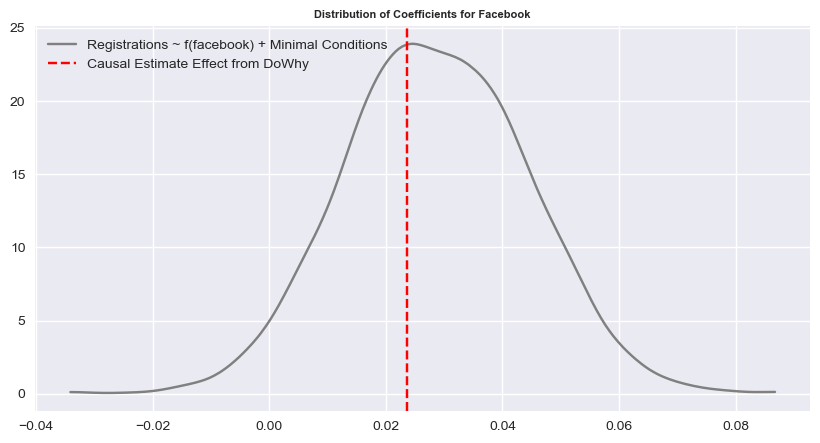

In [110]:
# Create a plot of the distributions comparing the coeff for facebook
channel_name = "paidm_soc_fb_excl_cbpr2_imp"

samples1 = facebook_direct_effect_idata1.posterior["gamma"].sel(channel=f"{channel_name}").values.flatten()

fig, ax = plt.subplots(figsize=(10, 5))
az.plot_dist(facebook_direct_effect_idata1.posterior["gamma"].sel(channel=f"{channel_name}"), ax=ax, label='Registrations ~ f(facebook) + Minimal Conditions', color="grey")
ax.set_title("Distribution of Coefficients for Facebook")
ax.legend(loc="upper right")

# Vertical line with res_subset.estimated_effect
ax.axvline(x=res_subset.estimated_effect, color="red", linestyle="--", label="Causal Estimate Effect from DoWhy")

plt.legend()
plt.show()